**COREIPG**

In [58]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import Optimizer
from torch.optim import Adam, SGD
from tqdm import tqdm

def rosenbrock(x):
    """
    Evaluate Rosenbrock function.
    Parameters: x - tensor of length 2
    """
    return (1 - x[0]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2

def square(x):
    return 2*torch.inner(x,x)

format_value = "{:.3f}"

In [59]:
class IPGDescent(Optimizer):
    """
    STEP 1 - Do SGD
    read grad and backward
    STEP 2 - Write the hessian module - Newton
    STEP 3 - Precondition
    """

    def __init__(self, parameters, lr=1e-3):
        defaults = {"lr": lr}
        super().__init__(parameters, defaults)

        # for p in self.get_params():
        #     self.state[p] = {}

        self.state["n"] = parameters[0].size(dim=0)
        self.state["iter"] = 0
        self.state["norm_grad_hist"] = []
        # self.state["curr_K"] = torch.zeros(self.state["n"], self.state["n"], \
        #                                    requires_grad=False, dtype=torch.float64)
        self.state["curr_K"] = torch.eye(self.state["n"], dtype=torch.float64)
        # self.state["K_hist"] = [self.state["curr_K"]]
        self.state["curr_alpha"] = 1e-2
        self.state["curr_beta"] = 5
        self.state["alpha_hist"] = [self.state["curr_alpha"]]
        self.state["beta_hist"] = [self.state["curr_beta"]]
        self.state["delta"] = 1e-1
        self.state["Id"] = torch.eye(self.state["n"], dtype=torch.float64)


    # def get_param_count(self):
    #     self.state["param_count"] = 0
    #     for group in self.param_groups:
    #       for p in group['params']:
    #           if p.grad is None or p.hess is None: continue
    #           current_param_state = self.state[p]
    #           # State initialization
    #           if len(current_param_state) == 0:
    #             self.state["param_count"] += 1
    #             print("=========================================================")
    #             print("encountering new parameter, current param count = ", \
    #                   self.state["param_count"])


    def get_params(self):
        """
        Gets all parameters in all param_groups with gradients
        """
        return [p for group in self.param_groups for p in group['params'] if p.requires_grad]

    def step(self, function, closure=None):
        """
        Work with p being a 1D param tensor
        """
        loss = None
        if closure is not None:
            loss = closure()

        self.state["iter"] += 1

        # print("=================================================================")
        # print("self.state[iter] = ", self.state["iter"])
        # print("=================================================================")
        # print("get params output - ", self.get_params())
        # print("=================================================================")
        # print("param_groups - ", self.param_groups)

        # self.zero_hessian()
        # self.set_hessian()

        for group in self.param_groups:
          for p in group['params']:

            # grad and hessian calc
            grad = torch.func.grad(function, argnums=0)(p)
            # print("grad dtype - ", grad.dtype)
            norm = torch.linalg.vector_norm(grad).detach().item()
            # print("norm_gf = ", format_value.format(norm))
            self.state["norm_grad_hist"].append(norm)

            hess = torch.func.hessian(function)(p)
            # print("hess = ", hess)
            # hess = torch.zeros(self.state["n"], self.state["n"], dtype=torch.float64)
            # self.state["curr_K"] = torch.eye(self.state["n"], dtype=torch.float64)
            # print( "k dtype - ", self.state["curr_K"].dtype)

            with torch.no_grad():
                # hess eigval check, alpha beta limit display
                self.state["eig_list"] =  torch.real(torch.linalg.eigvals(hess))
                # print("eig_list = ", self.state["eig_list"])
                alpha_lim = 1 / (torch.max(self.state["eig_list"]).item() + self.state["curr_beta"])
                beta_lim = -torch.min(self.state["eig_list"]).item()

                # print("alpha lim = ", alpha_lim, ",\t beta lim = ", beta_lim)

                # alpha beta clip
                if self.state["curr_alpha"] > alpha_lim:
                  self.state["curr_alpha"] = alpha_lim - 0.1*alpha_lim
                if self.state["curr_beta"] < beta_lim:
                  self.state["curr_beta"] = beta_lim + 0.1*beta_lim


            # update K, p
            precon = torch.matmul(self.state["curr_K"], grad)

            # backtracking
            with torch.no_grad():
                rho = 0.8
                c1 = 0.5
                while not function(p+self.state["delta"]*precon) <= (function(p) \
                          + c1*(torch.matmul(grad, precon))): self.state["delta"] = self.state["delta"]*rho

            # print("delta", self.state["delta"])
            p.data.sub_(precon, alpha=self.state["delta"])

            inter = torch.matmul((hess + self.state["curr_beta"]*self.state["Id"]), self.state["curr_K"])
            self.state["curr_K"].add_(inter, alpha=-self.state["curr_alpha"])
            self.state["curr_K"].add_(self.state["Id"], alpha=self.state["curr_alpha"])

            #log other metrics
            self.state["alpha_hist"].append(self.state["curr_alpha"])
            self.state["beta_hist"].append(self.state["curr_beta"])


        return loss, self.state


def run_optimizer(function, param_init, n_iter):
    """
    Collects function to be optimized and initial parameters (1D np array)
    Runs the optimizer for n_iterations
    """

    path = [param_init.tolist()]
    params = torch.tensor(param_init, requires_grad=True)

    optimizer = IPGDescent([params], lr = 1e-3)
    loss_hist = []

    for i in range(1, n_iter + 1):
        optimizer.zero_grad()
        loss = function(params)
        # print("===============================================================")
        # print("loss - ", format_value.format(loss))
        loss_hist.append(loss.item())
        # keeps track of best parameters
        # if loss < best_cost:
        #     best_cost = loss
        #     best_params = params

        # Update params
        if i==n_iter: final_loss, opt_state = optimizer.step(function)
        else: optimizer.step(function)
        path.append(params.detach().numpy().tolist())

    return path, opt_state, loss_hist


Simple quadratic fucntion

In [60]:
def qfunc(x):
    return 0.01*x[0]**2 + 0.1*x[1]**2

def quadfunc(x,y):
    return .01*x**2 + .1*y**2

test = np.array([-2.,2.])
n_iter = 4000
path, opt_state, loss_hist = run_optimizer(qfunc, test, n_iter)


In [61]:
# print(opt_state["curr_delta"])
# print(loss_hist)
# print(opt_state)
# plt.plot(np.log(opt_state["norm_grad_hist"]))
# print(path)



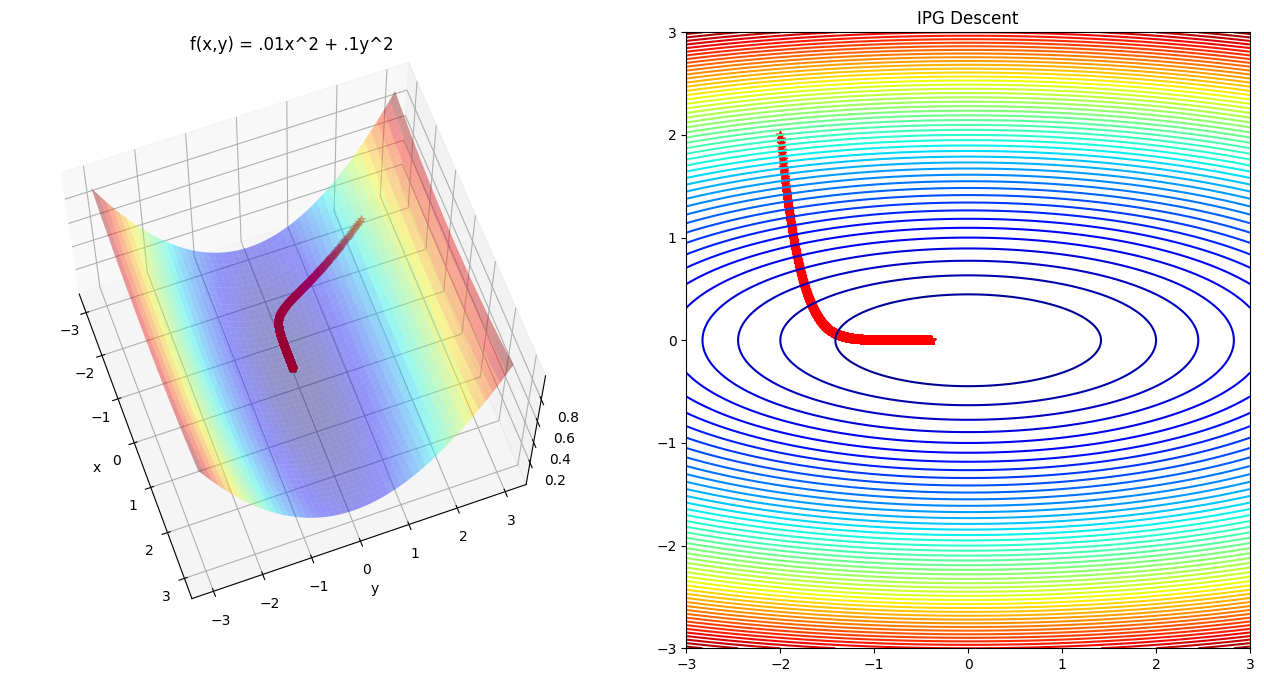

In [62]:
%matplotlib inline
fig = plt.figure(figsize = (16,8))

x = np.linspace(-3,3,250)
y = np.linspace(-3,3,250)
X, Y = np.meshgrid(x, y)
Z = quadfunc(X, Y)

iter_x = np.array(path)[:,0]
iter_y = np.array(path)[:,1]

#Angles needed for quiver plot
anglesx = iter_x[1:] - iter_x[:-1]
anglesy = iter_y[1:] - iter_y[:-1]

#Surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X,Y,Z,rstride = 5, cstride = 5, cmap = 'jet', alpha = .4, edgecolor = 'none' )
ax.plot(iter_x,iter_y, quadfunc(iter_x,iter_y),color = 'r', marker = '*', alpha = .4)
ax.set_title('f(x,y) = .01x^2 + .1y^2')

ax.view_init(65, 340)
ax.set_xlabel('x')
ax.set_ylabel('y')

#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(X,Y,Z, 50, cmap = 'jet')
#Plotting the iterations and intermediate values
ax.scatter(iter_x,iter_y,color = 'r', marker = '*')
ax.quiver(iter_x[:-1], iter_y[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .3)
ax.set_title('IPG Descent')

plt.show()